In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [176]:
otu_df = pd.read_csv('dataframes/OTU.csv', sep='\t', index_col='OTU')
taxonomy_df = pd.read_csv('dataframes/hiera_BLAST.csv', sep='\t', index_col='OTU')
metadata_df = pd.read_csv('dataframes/YOGURT-MAP.csv', sep='\t', index_col='#SampleID')
path_df = pd.read_csv('dataframes/path_df.csv', sep = ',')
metadata_df = metadata_df.drop(columns=['fastqFile', 'Weight'])
otu_df_meta = otu_df.transpose()
merged = otu_df_meta.merge(metadata_df, left_index=True, right_index=True)
merged = merged.reindex(['Group'] + list(merged.columns[:-1]), axis=1)
merged = merged[~merged['Group'].isin(['w4_con', 'w1_sch', 'w1_pry'])]
merged['Group'] = merged['Group'].replace({'w1_con':'CN', 'w4_pry':'CMY', 'w4_sch':'CMC'})
#merged = merged.drop(['AB10','BA10'])
merged_absolute = merged.copy()
#merged_absolute.to_excel('dataframes/output_data/16.07/taxonomy/initail_data_tax.xlsx')
#merged_absolute.to_csv('dataframes/output_data/16.07/taxonomy/initail_data_tax.csv', sep='\t', index=True)


In [177]:
genus_df = otu_df.groupby(taxonomy_df['Genus']).sum()
family_df = otu_df.groupby(taxonomy_df['Family']).sum()
genus_df = genus_df.T
genus_df = genus_df.merge(metadata_df, left_index=True, right_index=True)
genus_df = genus_df.reindex(['Group'] + list(genus_df.columns[:-1]), axis=1)
genus_df = genus_df[~genus_df['Group'].isin(['w4_con', 'w1_sch', 'w1_pry'])]
genus_df['Group'] = genus_df['Group'].replace({'w1_con':'CN', 'w4_pry':'CMY', 'w4_sch':'CMC'})
genus_df = genus_df.drop(columns={'?'})
cols = genus_df.columns.tolist()
modified_cols = [cols[0], cols[1]] + ["g_" + col for col in cols[2:]]
genus_df.columns = modified_cols
genus_df = genus_df.rename(columns={'A2':'g_A2'})

In [178]:
import pandas as pd

# Предполагается, что df - ваш текущий DataFrame

# Фильтрация по группам "CN" и "CMC"
genus_df_cmc = genus_df[genus_df['Group'].isin(['CN', 'CMC'])]
genus_df_cmy = genus_df[genus_df['Group'].isin(['CN', 'CMY'])]

In [179]:

def relative_abundance(df):
    # Создаем копию набора данных для избежания предупреждения
    df_copy = df.copy()
    # Добавляем столбец с общим количеством OTU для каждого образца
    df_copy['OTU_total'] = df_copy.iloc[:, 1:].sum(axis=1)

    # Рассчитываем относительное изобилие
    df_copy.loc[:, df_copy.columns[1:-1]] = df_copy.loc[:, df_copy.columns[1:-1]].div(df_copy['OTU_total'], axis=0)

    # Удаляем столбец OTU_total, так как он нам больше не нужен
    df_copy.drop(columns=['OTU_total'], inplace=True)
    # df_copy = df_copy.applymap(lambda x: str(x).replace('.', ','))
    # df_copy.T.to_excel('dataframes/output_data/16.07/taxonomy/otu_relative_abundance.xlsx')
    return df_copy.loc[:, (df_copy != df_copy.iloc[0]).any()] 


rel_genus_df_cmc = relative_abundance(genus_df_cmc)
rel_genus_df_cmy = relative_abundance(genus_df_cmy)


In [180]:
import scipy.stats as stats

def kruskal_pvalues_filter(df, group1):
    # Разделяем датафрейм на две группы
    group_cmc = df[df['Group'] == group1]
    group_cn = df[df['Group'] == 'CN']

    # Тест Kruskal-Wallis
    kruskal_pvalues = [stats.kruskal(group_cmc[otu], group_cn[otu], nan_policy='omit')[1] for otu in df.columns[1:]]

    # Создание DataFrame для хранения результатов
    results = pd.DataFrame({
        'OTU': df.columns[1:],
        'Kruskal_pvalue': kruskal_pvalues,
    })

    # Средние значения для каждой группы
    results['CN_mean'] = group_cn.mean(numeric_only=True).values
    results[f'{group1}_mean'] = group_cmc.mean(numeric_only=True).values

    results = results.loc[results['CN_mean'] > 0.001]
    results = results.loc[results[f'{group1}_mean'] > 0.001]
    return results.loc[(results['Kruskal_pvalue'] <= 0.05)]

kruskal_genus_cmc = kruskal_pvalues_filter(rel_genus_df_cmc, 'CMC')
kruskal_genus_cmy = kruskal_pvalues_filter(rel_genus_df_cmy, 'CMY')


In [181]:
def transpose_df(df):    
    less_zero_five_transposed = df.T
    less_zero_five_transposed.columns = less_zero_five_transposed.iloc[0]
    return less_zero_five_transposed[1:]

kruskal_genus_cmc_transposed = transpose_df(kruskal_genus_cmc)
kruskal_genus_cmy_transposed = transpose_df(kruskal_genus_cmy)

def preparing_data(started_df, transposed_df):
    # Сначала получим список всех OTU в merged_deleted_cmc_rel
    all_otus_in_merged = started_df.columns.to_list()

    # Затем получим список всех OTU в less_zero_five_transposed
    otus_in_less_zero_five_transposed = transposed_df.columns.to_list()

    # Определим, какие OTU присутствуют в merged_deleted_cmc_rel, но отсутствуют в less_zero_five_transposed
    otus_to_drop = [otu for otu in all_otus_in_merged if otu not in otus_in_less_zero_five_transposed and otu != 'Group']

    # Теперь удалим эти столбцы из merged_deleted_cmc_rel
    return started_df.drop(columns=otus_to_drop)

merged_deleted_cmc_rel_dropped = preparing_data(rel_genus_df_cmc, kruskal_genus_cmc_transposed)
merged_deleted_cmy_rel_dropped = preparing_data(rel_genus_df_cmy, kruskal_genus_cmy_transposed)
merged_deleted_cmc_rel_dropped

,Group,g_Alistipes,g_Alloprevotella,g_Bacteroides,g_Bifidobacterium,g_Candidatus Saccharimonas,g_Colidextribacter,g_Incertae Sedis,g_Lachnospiraceae NK4A136 group,g_Papillibacter,g_Parabacteroides,g_Prevotella,g_Prevotella_9,g_Prevotellaceae Ga6A1 group,g_Prevotellaceae NK3B31 group,g_Rikenellaceae RC9 gut group,g_Ruminococcus,g_UCG-003
AB1,CN,0.001712,0.009596,0.003231,0.001664,0.002859,0.012973,0.000711,0.009402,0.000695,0.004006,0.013942,0.496511,0.000598,0.094265,0.024976,0.011244,0.005525
AB10,CN,0.001585,0.002059,0.003306,0.021411,0.001160,0.007025,0.000699,0.006301,0.000399,0.002832,0.001909,0.628228,0.000699,0.026003,0.009882,0.015684,0.002271
AB2,CN,0.003510,0.003777,0.009564,0.002861,0.005278,0.009691,0.000992,0.010327,0.001450,0.004362,0.002213,0.611553,0.001017,0.091402,0.025830,0.005939,0.002340
AB3,CN,0.003060,0.002699,0.003101,0.003575,0.001041,0.008963,0.000948,0.031217,0.000577,0.001710,0.001607,0.776199,0.000474,0.062732,0.007407,0.003462,0.002864
AB4,CN,0.007377,0.004122,0.005251,0.010987,0.020478,0.040142,0.003977,0.049278,0.006642,0.003649,0.005999,0.353439,0.002127,0.034602,0.012575,0.026844,0.018181
AB5,CN,0.003029,0.003425,0.005903,0.001685,0.001388,0.006487,0.000969,0.010242,0.000341,0.001608,0.007940,0.781952,0.002588,0.030044,0.014846,0.007775,0.001839
AB6,CN,0.002072,0.002377,0.003628,0.002629,0.002850,0.006763,0.000684,0.005227,0.000410,0.002398,0.002461,0.769252,0.001010,0.028533,0.007004,0.004217,0.003418
AB7,CN,0.006687,0.005870,0.006706,0.004089,0.003216,0.021280,0.001236,0.022097,0.000890,0.006851,0.006669,0.259790,0.001272,0.038925,0.024423,0.009522,0.007069
AB8,CN,0.003346,0.006117,0.006873,0.002744,0.000728,0.019597,0.000672,0.007307,0.000616,0.005277,0.011842,0.479059,0.000630,0.025743,0.016210,0.010779,0.006635
AB9,CN,0.004369,0.005904,0.006221,0.001994,0.016746,0.066431,0.001520,0.026592,0.001330,0.004511,0.004353,0.361186,0.001361,0.072620,0.023188,0.011903,0.006822


In [182]:
def preoprazovanie(df):

    log = df.copy()
    data_columns = log.columns[1:]
    log[data_columns] = np.log1p(log[data_columns])

    z_norm = df.copy()
    cols_to_standardize = z_norm.columns[2:]

    for col in cols_to_standardize:
        mean = z_norm[col].mean()
        std = z_norm[col].std()
        z_norm[col] = (z_norm[col] - mean) / std

    logarifm = df.copy()
    cols_to_log_transform = logarifm.columns[2:]

    for col in cols_to_log_transform:
        logarifm[col] = np.log(logarifm[col] + 1)
    
    minmax = df.copy()
    cols_to_normalize = df.columns[2:]

    for col in cols_to_normalize:
        minmax[col] = (minmax[col] - minmax[col].min()) / (minmax[col].max() - minmax[col].min())

        
    return logarifm, log, minmax, z_norm

logarifm_cmc, log_cmc, minmax_cmc, z_norm_cmc = preoprazovanie(merged_deleted_cmc_rel_dropped)
logarifm_cmy, log_cmy, minmax_cmy, z_norm_cmy = preoprazovanie(merged_deleted_cmy_rel_dropped)

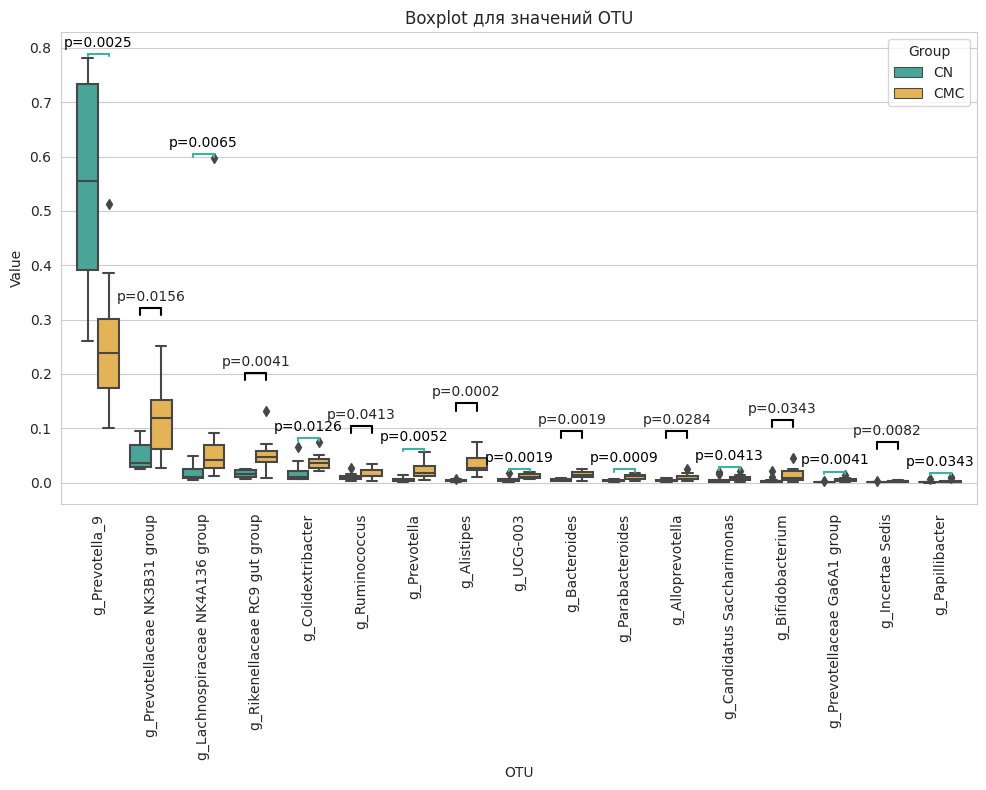

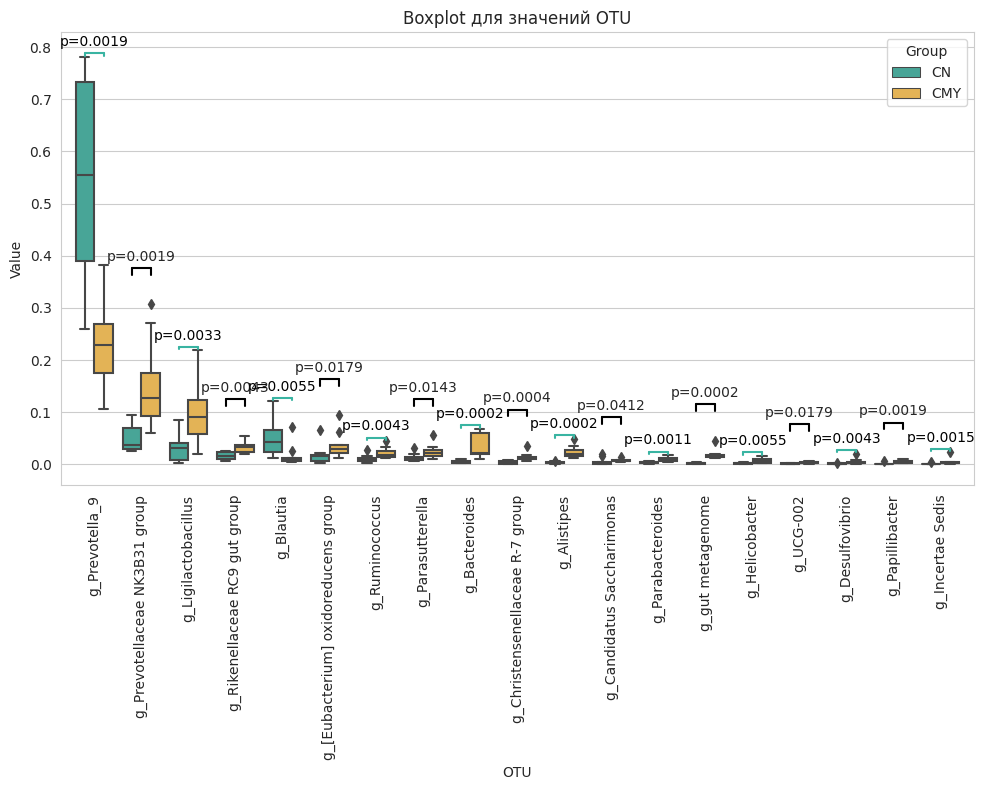

In [183]:
def relative_abundance_boxplot(df_dropped, transpose_df, df_group):
    # Преобразуем данные в длинный формат с помощью функции melt в pandas
    data_melt = df_dropped.melt(id_vars='Group', var_name='OTU', value_name='Value')

    my_palette = {'CN': '#39b4a2', 'CMC': '#faba3f', 'CMY': '#faba3f'} 

    # Фильтруем данные только для групп CN и CMC
    data_melt = data_melt[data_melt['Group'].isin(['CN', df_group])]

    # Создаем boxplot
    if df_group == "CMY":
        plt.figure(figsize=(10, 8))
    else:
        plt.figure(figsize=(10, 8))

    medians = data_melt.groupby('OTU')['Value'].median().sort_values(ascending=False)
    
    # Сортируем OTU в соответствии с их медианными значениями
    sorted_otus = medians.index.tolist()
    
    # Устанавливаем порядок для графика
    ax = sns.boxplot(data=data_melt, x='OTU', y='Value', hue='Group', order=sorted_otus, palette=my_palette)

    # Получаем значения p-value
    p_values = transpose_df.loc['Kruskal_pvalue'].to_dict()

    # Находим максимальное значение y для каждого OTU
    y_max_values = data_melt.groupby('OTU')['Value'].max()

    # Выводим значения p-value и линии для групп 'CN' и 'CMC'
    for i, otu in enumerate(sorted_otus):
        p_value = p_values.get(otu, np.nan)
        y_max = y_max_values[otu]
        if i % 2==0:
            height = 0.007
            ax.annotate(f'p={p_value:.4f}', xy=(i, y_max + height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom', fontsize=10, color = 'black')
        else:
            height = 0.07
            ax.annotate(f'p={p_value:.4f}', xy=(i, y_max + height), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom', fontsize=10)
        
        # Добавляем вертикальные линии
        x1 = i - 0.2
        x2 = i + 0.2
        
        line_width = 1.5
        y_line = y_max + height  # Y-координата горизонтальной линии
        if i % 2==0:
            line_color = '#39b4a2'
            ax.plot([x1, x1], [y_max+.002, y_line], color=line_color, lw=line_width)
            ax.plot([x2, x2], [y_max+.002, y_line], color=line_color, lw=line_width)
            ax.plot([x1, x2], [y_line, y_line], color=line_color, lw=line_width)  # Горизонтальная линия
        else:
            line_color = 'black'
            ax.plot([x1, x1], [y_max+.057, y_line], color=line_color, lw=line_width)
            ax.plot([x2, x2], [y_max+.057, y_line], color=line_color, lw=line_width)
            ax.plot([x1, x2], [y_line, y_line], color=line_color, lw=line_width)  # Горизонтальная линия

    # Показываем график
    plt.title('Boxplot для значений OTU')
    plt.xticks(rotation=90)
    plt.tight_layout()
    # if df_group == "CMY":
    #     plt.savefig('figures/realtive_ab/seaborn_boxplot_cmy.pdf', bbox_inches = 'tight')
    # else:
    #     plt.savefig('figures/realtive_ab/seaborn_boxplot_cmc.pdf', bbox_inches = 'tight')
    plt.show()

# logarifm_cmc, log_cmc, minmax_cmc, z_norm_cmc merged_deleted_cmc_rel_dropped
# logarifm_cmy, log_cmy, minmax_cmy, z_norm_cmy merged_deleted_cmy_rel_dropped


relative_abundance_boxplot(merged_deleted_cmc_rel_dropped, kruskal_genus_cmc_transposed, 'CMC') #Логарифмическая нормализация
relative_abundance_boxplot(merged_deleted_cmy_rel_dropped, kruskal_genus_cmy_transposed, 'CMY') 

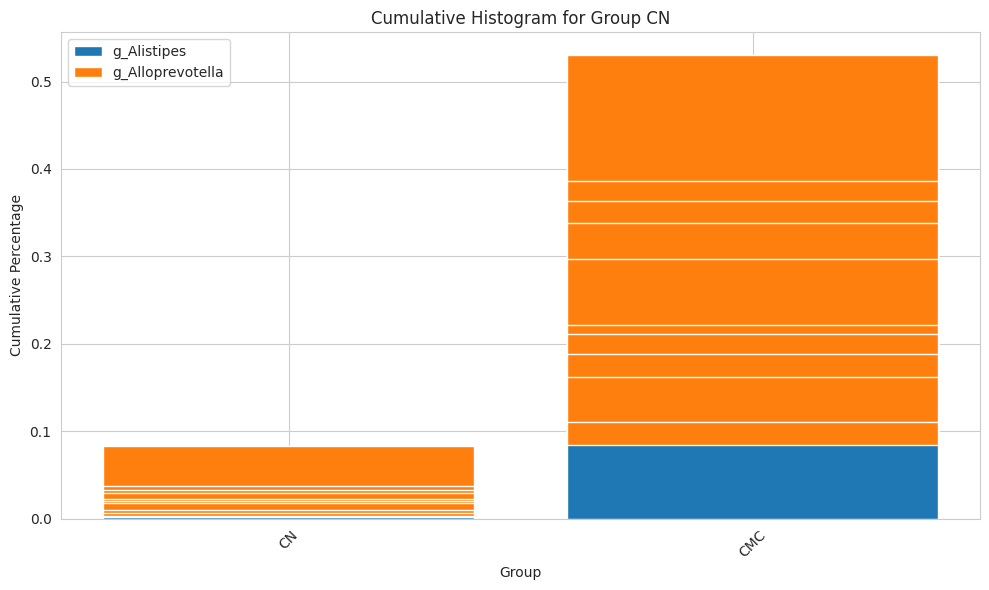

In [195]:

# Добавление столбца с накопительной суммой для каждой бактерии
for column in merged_deleted_cmc_rel_dropped.columns[1:]:
    merged_deleted_cmc_rel_dropped[column] = merged_deleted_cmc_rel_dropped[column].cumsum()

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.bar(merged_deleted_cmc_rel_dropped["Group"], merged_deleted_cmc_rel_dropped["g_Alistipes"], label="g_Alistipes")
plt.bar(merged_deleted_cmc_rel_dropped["Group"], merged_deleted_cmc_rel_dropped["g_Alloprevotella"], bottom=merged_deleted_cmc_rel_dropped["g_Alistipes"], label="g_Alloprevotella")
# Добавьте остальные бактерии сюда

plt.xlabel("Group")
plt.ylabel("Cumulative Percentage")
plt.title("Cumulative Histogram for Group CN")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Отображение графика
plt.show()